In [43]:
%matplotlib notebook

import matplotlib.pyplot as plt
import datetime
from __future__ import division
from random import choice
from math import log, sqrt

<IPython.core.display.Javascript object>


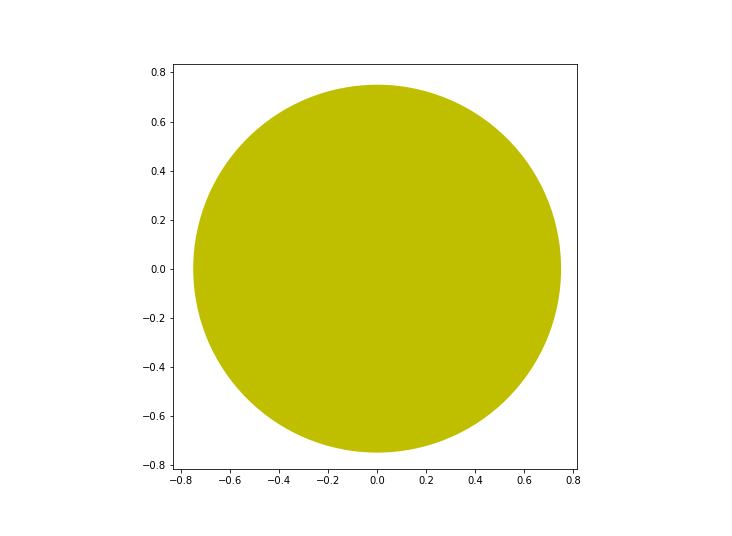

In [10]:
plt.axes()

circle = plt.Circle((0, 0), radius=0.75, fc='y')
plt.gca().add_patch(circle)

plt.axis('scaled')
plt.show()

In [84]:
class Board(object):
    def __init__(self, n, m, d, Rs, Rc, O):
        self.n = n
        self.m = m
        self.d = d
        self.Rs = Rs
        self.Rc = Rc
        self.O = O
        O2 = []
        for x1, y1, x2, y2 in O:
            for x in range(x1, x2+1):
                for y in range(y1, y2+1):
                    O2.append((x, y))
        self.O2 = O2
        self.O2set = set(O2)
    
    def start(self):
        # Returns a representation of the starting state of the game.
        return [(-1,-1)] * self.m

    def next_state(self, state, play):
        # Takes the game state, and the move to be applied.
        # Returns the new game state.
        t = next(i for i,p in enumerate(state) if p[0] < 0 or p[1] < 0)
        state_copy = state[:]
        state_copy[t] = play
        return state_copy

    def legal_plays(self, state_history):
        # Takes a sequence of game states representing the full
        # game history, and returns the full list of moves that
        # are legal plays for the current player.
        state = state_history[-1]
        legal = []
        t = next(i for i,p in enumerate(state) if p[0] < 0 or p[1] < 0)
        n = self.n
        m = self.m
        Rs = self.Rs
        Rc = self.Rc
        if t == 0:
            # First iteration anywhere but inside obstacles
            for j in range(0, n+1):
                for k in range(0, n+1):
                    if (j, k) not in self.O2set:
                        legal.append((j, k))
        else:
            # Loop through deployed positions
            for i in range(0, t):
                x, y = state[i]
                # Eliminate out of bound positions
                if x < 0 or y < 0 or x > n or y > n:
                    continue
                # Loop through possible deploy positions
                # (j, k) = possible position
                for j in range(x - Rc[i] - Rc[t] + 1, x + Rc[i] + Rc[t]):
                    for k in range(y - Rc[i] - Rc[t] + 1, y + Rc[i] + Rc[t]):
                        # Eliminate out of bound positions
                        if j < 0 or k < 0 or j > n or k > n:
                            continue
                        # Eliminate deployed positions
                        if (j, k) in state:
                            continue
                        overlap = []
                        # Loop through possible coverage
                        # (u, v) = points in sensor i
                        # Need to determine if (u, v) is in coverage of sensor t deployed at (j,k)
                        for u in range(x - Rc[i], x + Rc[i] + 1):
                            for v in range(y - Rc[i], y + Rc[i] + 1):
                                # Eliminate out of bound
                                if u < 0 or v < 0 or u > n or v > n:
                                    continue
                                # Eliminate out of circle
                                if sqrt((u-x)**2 + (v-y)**2) > Rc[i]:
                                    continue
                                # Determine if (u,v) is covered by sensor t
                                if sqrt((u-j)**2 + (v-k)**2) <= Rc[t]:
                                    overlap.append((u, v))
                        if len(overlap) >= 2 and set(overlap).issubset(self.O2set) is False:
                            legal.append((j,k))
        return legal

    def winner(self, state_history):
        # Takes a sequence of game states representing the full
        # game history.  If the game is now won, return the player
        # number.  If the game is still ongoing, return zero.  If
        # the game is tied, return a different distinct value, e.g. -1.
        pass

In [ ]:
class MonteCarlo(object):
    def __init__(self, board, **kwargs):
        # Takes an instance of a Board and optionally some keyword
        # arguments.  Initializes the list of game states and the
        # statistics tables.
        self.board = board
        self.states = []
        seconds = kwargs.get('time', 30)
        self.calculation_time = datetime.timedelta(seconds=seconds)
        self.max_moves = kwargs.get('max_moves', 100)
        self.scores = {}
        self.plays = {}
        pass

    def update(self, state):
        # Takes a game state, and appends it to the history.
        self.states.append(state)
        pass

    def get_play(self):
        # Causes the AI to calculate the best move from the
        # current game state and return it.
        self.max_depth = 0
        state = self.states[-1]
        legal = self.board.legal_plays(self.states[:])

        # Bail out early if there is no real choice to be made.
        if not legal:
            return
        if len(legal) == 1:
            return legal[0]

        games = 0
        begin = datetime.datetime.utcnow()
        while datetime.datetime.utcnow() - begin < self.calculation_time:
            self.run_simulation()
            games += 1

        moves_states = [(p, self.board.next_state(state, p)) for p in legal]

        # Display the number of calls of `run_simulation` and the
        # time elapsed.
        print games, datetime.datetime.utcnow() - begin

        # Pick the move with the highest percentage of scores.
        percent_scores, move = max(
            (self.scores.get((S), 0) /
             self.plays.get((S), 1),
             p)
            for p, S in moves_states
        )

        # Display the stats for each possible play.
        for x in sorted(
            ((100 * self.scores.get((S), 0) /
              self.plays.get((S), 1),
              self.scores.get((S), 0),
              self.plays.get((S), 0), p)
             for p, S in moves_states),
            reverse=True
        ):
            print "{3}: {0:.2f}% ({1} / {2})".format(*x)

        print "Maximum depth searched:", self.max_depth

        return move

    def run_simulation(self):
        # Plays out a "random" game from the current position,
        # then updates the statistics tables with the result.
        
        # A bit of an optimization here, so we have a local
        # variable lookup instead of an attribute access each loop.
        plays, scores = self.plays, self.scores

        visited_states = set()
        states_copy = self.states[:]
        state = states_copy[-1]

        expand = True
        for t in xrange(1, self.max_moves + 1):
            legal = self.board.legal_plays(states_copy)
            moves_states = [(p, self.board.next_state(state, p)) for p in legal]

            if all(plays.get((S)) for p, S in moves_states):
                # If we have stats on all of the legal moves here, use them.
                log_total = log(
                    sum(plays[(S)] for p, S in moves_states)
                )
                value, move, state = max(
                    ((scores[(S)] / plays[(S)]) +
                     self.C * sqrt(log_total / plays[(S)]), p, S)
                    for p, S in moves_states
                )
            else:
                # Otherwise, just make an arbitrary decision.
                move, state = choice(moves_states)

            states_copy.append(state)

            if expand and (state) not in plays:
                expand = False
                plays[(state)] = 0
                scores[(state)] = 0
                if t > self.max_depth:
                    self.max_depth = t

            visited_states.add((state))

            winner = self.board.winner(states_copy)
            if winner:
                break

        for state in visited_states:
            if (state) not in plays:
                continue
            plays[(state)] += 1
            scores[(state)] += 1

In [14]:
class MonteCarlo(object):
    def __init__(self, board, **kwargs):
        # Takes an instance of a Board and optionally some keyword
        # arguments.  Initializes the list of game states and the
        # statistics tables.
        self.board = board
        self.states = []
        seconds = kwargs.get('time', 30)
        self.calculation_time = datetime.timedelta(seconds=seconds)
        self.max_moves = kwargs.get('max_moves', 100)
        self.scores = {}
        self.plays = {}
        pass

    def update(self, state):
        # Takes a game state, and appends it to the history.
        self.states.append(state)
        pass

    def get_play(self):
        # Causes the AI to calculate the best move from the
        # current game state and return it.
        self.max_depth = 0
        state = self.states[-1]
        legal = self.board.legal_plays(self.states[:])

        # Bail out early if there is no real choice to be made.
        if not legal:
            return
        if len(legal) == 1:
            return legal[0]

        games = 0
        begin = datetime.datetime.utcnow()
        while datetime.datetime.utcnow() - begin < self.calculation_time:
            self.run_simulation()
            games += 1

        moves_states = [(p, self.board.next_state(state, p)) for p in legal]

        # Display the number of calls of `run_simulation` and the
        # time elapsed.
        print games, datetime.datetime.utcnow() - begin

        # Pick the move with the highest percentage of scores.
        percent_scores, move = max(
            (self.scores.get((S), 0) /
             self.plays.get((S), 1),
             p)
            for p, S in moves_states
        )

        # Display the stats for each possible play.
        for x in sorted(
            ((100 * self.scores.get((S), 0) /
              self.plays.get((S), 1),
              self.scores.get((S), 0),
              self.plays.get((S), 0), p)
             for p, S in moves_states),
            reverse=True
        ):
            print "{3}: {0:.2f}% ({1} / {2})".format(*x)

        print "Maximum depth searched:", self.max_depth

        return move

    def run_simulation(self):
        # Plays out a "random" game from the current position,
        # then updates the statistics tables with the result.
        
        # A bit of an optimization here, so we have a local
        # variable lookup instead of an attribute access each loop.
        plays, scores = self.plays, self.scores

        visited_states = set()
        states_copy = self.states[:]
        state = states_copy[-1]

        expand = True
        for t in xrange(1, self.max_moves + 1):
            legal = self.board.legal_plays(states_copy)
            moves_states = [(p, self.board.next_state(state, p)) for p in legal]

            if all(plays.get((S)) for p, S in moves_states):
                # If we have stats on all of the legal moves here, use them.
                log_total = log(
                    sum(plays[(S)] for p, S in moves_states)
                )
                value, move, state = max(
                    ((scores[(S)] / plays[(S)]) +
                     self.C * sqrt(log_total / plays[(S)]), p, S)
                    for p, S in moves_states
                )
            else:
                # Otherwise, just make an arbitrary decision.
                move, state = choice(moves_states)

            states_copy.append(state)

            if expand and (state) not in plays:
                expand = False
                plays[(state)] = 0
                scores[(state)] = 0
                if t > self.max_depth:
                    self.max_depth = t

            visited_states.add((state))

            winner = self.board.winner(states_copy)
            if winner:
                break

        for state in visited_states:
            if (state) not in plays:
                continue
            plays[(state)] += 1
            scores[(state)] += 1

SyntaxError: invalid syntax (<ipython-input-14-3164dcbc2a01>, line 43)

<IPython.core.display.Javascript object>


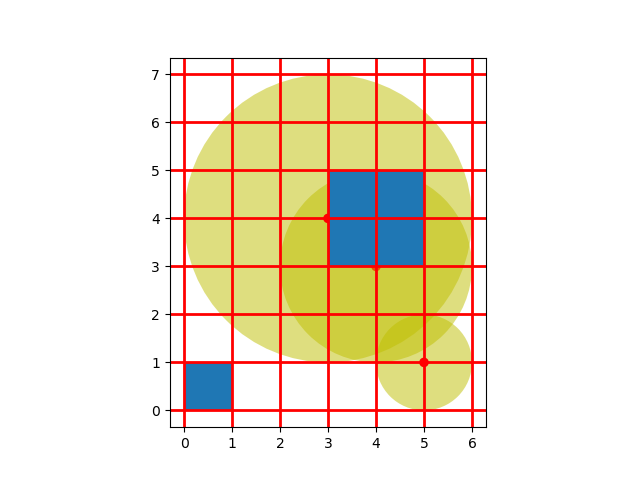

In [90]:
n = 5
m = 3
d = 2
Rs = (1,1,1)
Rc = (1,2,3)
O = [(0,0,1,1),(3,3,5,5)]
board = Board(n,m,d,Rs,Rc,O)
history = [board.start()]
for i in range(0,m):
    state = history[-1]
    play = choice(board.legal_plays(history))
    next_state = board.next_state(state, play)
    history.append(next_state)
deploy = history[-1]

plt.axes()

for i in range(0, m):
    x, y = deploy[i]
    circle = plt.Circle((x, y), radius=Rc[i], fc='y', alpha=0.5)
    plt.gca().add_patch(circle)
    circle = plt.Circle((x, y), radius=0.1, fc='r', alpha=1)
    plt.gca().add_patch(circle)

for j in range(0, d):
    x1, y1, x2, y2 = O[j]
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1)
    plt.gca().add_patch(rect)
    
plt.axis('scaled')
plt.grid(color='r', linestyle='-', linewidth=1)
plt.show()

In [72]:
u=1
y=2
x=3
v=4
sqrt((u-x)**2 + (v-y)**2)

2.8284271247461903